In [1]:
#Importing the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from IPython.display import display
import random

Using TensorFlow backend.


In [2]:
#Reading the traning file
train = pd.read_csv('./data/train_2.csv').fillna(0)
page = train['Page']
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [11]:
# sum all data columns to get full usage
df = pd.DataFrame(train.loc[:,'2015-07-01':].sum(axis=0))
df.head()

,0
2015-07-01,148672476.0
2015-07-02,149593840.0
2015-07-03,141164198.0
2015-07-04,145612937.0
2015-07-05,151495372.0


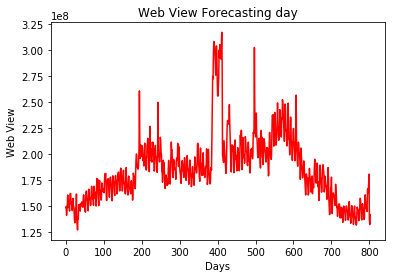

In [17]:
data = df.iloc[:,0].values

plt.figure
plt.plot(data, color = 'red')
plt.title('Web View Forecasting day')
plt.xlabel('Days')
plt.ylabel('Web View')
plt.show()

In [29]:
# how many days will you get to predict your model
INPUT_DAYS = 40
# number of days in future model will try to predict
OUTPUT_DAYS = 10
# number of days used to train
WINDOW_RANGE = 365
# number of shift for val data
SHIFT_VAL = 30

def createLSTMModel():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(input_shape = (INPUT_DAYS, 1), units=30, return_sequences=True))
    regressor.add(Dropout(0.5))
    regressor.add(LSTM(256))
    regressor.add(Dropout(0.25))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

def createLSTMModelOld():
    regressor = Sequential()
    # Adding the input layerand the LSTM layer
    regressor.add(LSTM(units = 24, activation = 'relu', input_shape = (INPUT_DAYS, 1)))
    # Adding the output layer
    regressor.add(Dense(units = 1))
    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

def createRegressionModel():
    model = Sequential()
    model.add(Dense(4, input_dim=INPUT_DAYS, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    return model

def calculateError(y_test, y_pred):
    rms = np.sqrt(mean_squared_error(y_test, y_pred))
    return rms

In [30]:
X_train = np.empty((0,INPUT_DAYS))
Y_train = np.empty((0,OUTPUT_DAYS))
X_val = np.empty((0,INPUT_DAYS))
Y_val = np.empty((0,OUTPUT_DAYS))

X_train = np.reshape(data[0:WINDOW_RANGE],(-1,1))
X_val = np.reshape(data[SHIFT_VAL:WINDOW_RANGE+SHIFT_VAL],(-1,1))
for i in range(1,INPUT_DAYS):
    x_train = data[i:WINDOW_RANGE+i]
    X_train = np.append(X_train, np.reshape(x_train,(-1,1)), axis=1)
    x_val = data[i+SHIFT_VAL:WINDOW_RANGE+i+SHIFT_VAL]
    X_val = np.append(X_val, np.reshape(x_val,(-1,1)), axis=1)

Y_train = np.reshape(data[INPUT_DAYS:WINDOW_RANGE+INPUT_DAYS],(-1,1))
Y_val = np.reshape(data[INPUT_DAYS+SHIFT_VAL:WINDOW_RANGE+INPUT_DAYS+SHIFT_VAL],(-1,1))
for i in range(INPUT_DAYS+1, INPUT_DAYS+OUTPUT_DAYS):
    y_train = data[i:WINDOW_RANGE+i]
    Y_train = np.append(Y_train, np.reshape(y_train,(-1,1)), axis=1)
    y_val = data[i+SHIFT_VAL:WINDOW_RANGE+i+SHIFT_VAL]
    Y_val = np.append(Y_val, np.reshape(y_val,(-1,1)), axis=1)

# Feature Scaling
sc_X = MinMaxScaler(feature_range=(0, 1))
sc_Y = MinMaxScaler(feature_range=(0, 1))
X_train = sc_X.fit_transform(X_train)
Y_train = sc_Y.fit_transform(Y_train)
X_val = sc_X.transform(X_val)
Y_val = sc_Y.transform(Y_val)

#print(X_train.shape)
#print(Y_train.shape)

# Shuffle data in training dataset
train_data = np.append(X_train, Y_train, axis=1)
train_data = shuffle(train_data)
X_train = train_data[:,0:INPUT_DAYS]
Y_train = train_data[:,INPUT_DAYS:INPUT_DAYS+OUTPUT_DAYS+1]
#print(X_train.shape)
#print(Y_train.shape)

In [31]:
#Reshaping Array for Regression
#X_train = np.reshape(X_train, (WINDOW_RANGE,INPUT_DAYS))
#X_val = np.reshape(X_val, (WINDOW_RANGE,INPUT_DAYS))
#Reshaping Array for LSTM
X_train = np.reshape(X_train, (WINDOW_RANGE,INPUT_DAYS,1))
X_val = np.reshape(X_val, (WINDOW_RANGE,INPUT_DAYS,1))

# Initialising the RNN
regressors = []
for i in range(0,OUTPUT_DAYS):
    print("Generating model for day " + str(i))
    regressor = createLSTMModel()

    # Fitting the RNN to the Training set
    regressor.fit(X_train, Y_train[:,i], 
                  batch_size = 1024, 
                  epochs = 10, 
                  verbose = 1, 
                  validation_data=(X_val, Y_val[:,i]))
    regressors.append(regressor)

Generating model for day 0
Train on 365 samples, validate on 365 samples
Epoch 1/10
365/365 [==============================] - 3s 10ms/step - loss: 0.0958 - val_loss: 0.0803
Epoch 2/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0612 - val_loss: 0.0438
Epoch 3/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0333 - val_loss: 0.0210
Epoch 4/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0167 - val_loss: 0.0449
Epoch 5/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0267
Epoch 6/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0186
Epoch 7/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0204
Epoch 8/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0157 - val_loss: 0.0237
Epoch 9/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0185 - val_loss: 0.0256
Epoch 10/10
365/365 [=====

Epoch 7/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0229 - val_loss: 0.0236
Epoch 8/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0207 - val_loss: 0.0235
Epoch 9/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0212 - val_loss: 0.0245
Epoch 10/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0218 - val_loss: 0.0250
Generating model for day 8
Train on 365 samples, validate on 365 samples
Epoch 1/10
365/365 [==============================] - 5s 13ms/step - loss: 0.1114 - val_loss: 0.0797
Epoch 2/10
365/365 [==============================] - 1s 2ms/step - loss: 0.0738 - val_loss: 0.0462
Epoch 3/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0443 - val_loss: 0.0260
Epoch 4/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0232 - val_loss: 0.0464
Epoch 5/10
365/365 [==============================] - 1s 3ms/step - loss: 0.0329 - val_loss: 0.0418
Epoch 6/10
365/365 [=====

In [ ]:
X_value = random.randint(0,train.shape[0])
print(X_value)

# Getting the predicted Web View
test = data[WINDOW_RANGE:]

X_test = np.reshape(test[0:WINDOW_RANGE],(-1,1))
for i in range(1,INPUT_DAYS):
    x_test = test[i:WINDOW_RANGE+i]
    X_test = np.append(X_test, np.reshape(x_test,(-1,1)), axis=1)
    
y_test = np.reshape(test[INPUT_DAYS:WINDOW_RANGE+INPUT_DAYS],(-1,1))
for i in range(INPUT_DAYS+1, INPUT_DAYS+OUTPUT_DAYS):
    y = test[i:WINDOW_RANGE+i]
    y_test = np.append(y_test, np.reshape(y,(-1,1)), axis=1)

inputs = X_test
inputs = sc_X.transform(inputs)

# reshape for Regression
#inputs = np.reshape(inputs, (WINDOW_RANGE, INPUT_DAYS))
# reshape for LSTM
inputs = np.reshape(inputs, (WINDOW_RANGE, INPUT_DAYS,1))

Y_pred = np.empty((WINDOW_RANGE,0))
for i in range(0,OUTPUT_DAYS):
    regressor = regressors[i]
    y_pred = regressor.predict(inputs)
    #y_pred = sc_Y.inverse_transform(y_pred)
    #y_pred[y_pred < 0] = 0
    Y_pred = np.append(Y_pred, np.reshape(y_pred, (WINDOW_RANGE,1)), axis=1)

    #print(y_pred)
    
Y_pred = sc_Y.inverse_transform(Y_pred)
Y_pred[Y_pred < 0] = 0

#print(Y_pred)

all_errors = []
for i in range(0,OUTPUT_DAYS):
    error = calculateError(y_test[:,i], Y_pred[:,i])
    
    all_errors.append(error)
    
    display("Root Mean Square - Pred " + str(i+1) + ": " + str(error))

    #Visualising Result
    plt.figure
    plt.plot(y_test[:,i], color = 'red', label = 'Real Web View')
    plt.plot(Y_pred[:,i], color = 'blue', label = 'Predicted Web View')
    #plt.plot(X_test, color = 'green', label = 'Previous values')
    plt.title('Web View Forecasting day' + str(i+1))
    plt.xlabel('Number of Days')
    plt.ylabel('Web View')
    plt.legend()
    plt.show()

In [33]:
plt.figure
plt.plot(all_errors, color = 'red', label = 'Error by day')
plt.title('RMS Error by days in future')
plt.xlabel('Number of Days in Future')
plt.ylabel('RMS Error')
plt.legend()
plt.savefig("data.png")
plt.show()

NameError: name 'all_errors' is not defined